In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# XGBoost

[05:58:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:58:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:58:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


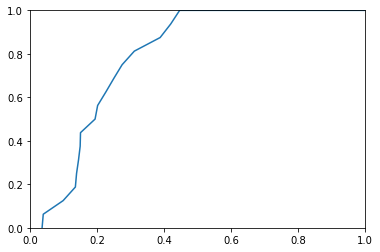

AUC:  0.7893616750074518


In [0]:
import warnings
from sklearn.cluster import KMeans
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
from math import sqrt
from pandas import read_csv
import pandas as pd
from pandas import DataFrame
from pandas import concat
import numpy as np 
from matplotlib import pyplot
from xgboost import XGBRegressor
from sklearn import preprocessing
import sys
from tensorflow import set_random_seed
set_random_seed(42)
from numpy.random import seed
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import numpy as np
from keras.layers import Conv1D,MaxPooling1D,Flatten
seed(42)
from keras import regularizers

def warn(*args, **kwargs):
    pass
    
class XGB_AnomalyDetection:
    def __init__(self,path, window_width, dimension, train_rate):

        self.dimension = dimension
        self.window_width = window_width


        self.df = read_csv(path, header=0, index_col=None, parse_dates=True,squeeze=True)
        self.df = self.df.reset_index(drop=True)
        self.df.rename(columns={'Target':'is_anomaly'}, inplace=True)
        self.df.loc[self.df.is_anomaly == "'Anomaly'", 'is_anomaly'] = 1
        self.df.loc[self.df.is_anomaly == "'Normal'", 'is_anomaly'] = 0

        df_sensors = pd.DataFrame(self.df.iloc[:,:dimension].values)  
        self.values = df_sensors
        self.dataframe = concat([self.df.iloc[:,:-1].shift(1), self.df.iloc[:,:-1], self.df.iloc[:,-1]], axis=1)
        self.dataframe.columns = np.r_[np.array(['V'+str(i)+'_t' for i in range(1,self.dimension+1)]),np.array(['V'+str(i)+'_t+1' for i in range(1,self.dimension+1)]),['is_anomaly']]

        # self.dataframe = concat([self.values.shift(1), self.values], axis=1)
        # self.dataframe.columns = ['t', 't+1']

        self.train_size = int(len(self.values) * train_rate)  

    def reset_dataframe(self, df, dimension, train_rate):
        self.df = df
        self.dimension = dimension
        self.df = self.df.reset_index(drop=True)
        self.df.rename(columns={'Target':'is_anomaly'}, inplace=True)
        self.df.loc[self.df.is_anomaly == "'Anomaly'", 'is_anomaly'] = 1
        self.df.loc[self.df.is_anomaly == "'Normal'", 'is_anomaly'] = 0

        df_sensors = pd.DataFrame(self.df.iloc[:,:dimension].values)  
        self.values = df_sensors
        self.dataframe = concat([self.df.iloc[:,:-1].shift(1), self.df.iloc[:,:-1], self.df.iloc[:,-1]], axis=1)
        self.dataframe.columns = np.r_[np.array(['V'+str(i)+'_t' for i in range(1,self.dimension+1)]),np.array(['V'+str(i)+'_t+1' for i in range(1,self.dimension+1)]),['is_anomaly']]



        self.train_size = int(len(self.values) * train_rate)         

    def create_XY_lookback_dataset(self,dataset, look_back=1):
        dataX, dataY = [], []
        for i in range(len(dataset)-look_back-1):
            a = dataset[i:(i+look_back),:self.dimension]
            dataX.append(a.reshape(-1))
            dataY.append(dataset[i + look_back,:self.dimension].reshape(-1))
        return numpy.array(dataX), numpy.array(dataY)
    
    def getWindowedVectors(self, X):
        vectors = np.zeros((len(X) - self.window_width+1,self.window_width))
        for i,_ in enumerate(X[:-self.window_width+1]):
            vectors[i] = X[i:i+self.window_width]
        return vectors

    def __build_sets(self):

        X = self.dataframe.iloc[:,:-1].values
        self.train, self.test = X[1:self.train_size], X[self.train_size:]    
        # print('Train.len:',len(self.train),' - Test.len:', len(self.test))

        self.train_X, self.train_y = self.create_XY_lookback_dataset(self.train, self.window_width)
        self.test_X, self.test_y = self.create_XY_lookback_dataset(self.test, self.window_width)
        # print('TrainX.shape:',self.train_X.shape,' - TestX.shape:', self.test_X.shape,' - TrainY.shape:', self.train_y.shape,' - TestY.shape:', self.test_y.shape)

        self.validationsize = int(self.train_X.shape[0] * 0.1)
        self.val, self.test = self.test[:self.validationsize], self.test[self.validationsize:]
        self.val_X, self.val_y= self.test_X[:self.validationsize], self.test_y[:self.validationsize]
        self.test_X, self.test_y = self.test_X[self.validationsize:], self.test_y[self.validationsize:]

    def standardize_dataframe(self):
        X = self.dataframe.values[:,:-1]
        self.scalar = preprocessing.StandardScaler().fit(X)
        X = self.scalar.transform(X)
        self.dataframe = pd.DataFrame(np.concatenate((X,self.dataframe.values[:,-1].reshape(-1,1)),axis=1))
        self.dataframe.columns = np.r_[np.array(['V'+str(i)+'_t' for i in range(1,self.dimension+1)]),np.array(['V'+str(i)+'_t+1' for i in range(1,self.dimension+1)]),['is_anomaly']]

    def inverse_standardize_dataframe(self):
        X = self.dataframe.values[:,:-1]
        X = self.scalar.inverse_transform(X)
        self.dataframe = pd.DataFrame(np.concatenate((X,self.dataframe.values[:,-1].reshape(-1,1)),axis=1))
        self.dataframe.columns = np.r_[np.array(['V'+str(i)+'_t' for i in range(1,self.dimension+1)]),np.array(['V'+str(i)+'_t+1' for i in range(1,self.dimension+1)]),['is_anomaly']]




    def model_persistence(self, x):
        return x
        
    def create_persistence(self):
        rmse = sqrt(mean_squared_error(self.dataframe.iloc[self.train_size:,:self.dimension], self.dataframe.iloc[self.train_size:,self.dimension:-1]))
        # print('Persistent Model RMSE: %.3f' % rmse)   

    def fit(self):
        self.create_persistence()
        self.standardize_dataframe()
        self.__build_sets()
                
        self.compute_anomalyScores()
        self.inverse_standardize_dataframe()
        self.compute_Errors_RMSE()


    def plotTraining(self):
        history_dict = self.history.history
        loss_values = history_dict['loss'][1:]
        val_loss_values = history_dict['val_loss'][1:]
        self.n_epochs = range(2, self.n_epochs + 1)
        plt.plot(self.n_epochs, loss_values, 'bo', label='Training loss')
        plt.plot(self.n_epochs, val_loss_values, 'b', label='Validation loss')
        plt.title('Training and validation loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

    def compute_anomalyScores(self):
        from sklearn.multioutput import MultiOutputRegressor

        # fitting
        multioutputregressor = MultiOutputRegressor(XGBRegressor(objective='reg:linear')).fit(self.train_X, self.train_y)

        # predicting
        self.predictions = multioutputregressor.predict(self.test_X) 
        # # self.train_X = numpy.reshape(self.train_X, (self.train_X.shape[0],self.dimension,self.train_X.shape[1]))
        # # self.test_X = numpy.reshape(self.test_X, (self.test_X.shape[0],self.dimension, self.test_X.shape[1]))

        # from keras.layers import Conv1D,MaxPooling1D,Flatten
        # self.model = Sequential()

        # self.model = Sequential()
        # self.model.add(LSTM(self.n_filters[0], batch_input_shape=(1, self.window_width, self.dimension), stateful=True, return_sequences=True))
        # self.model.add(LSTM(self.n_filters[1], batch_input_shape=(1, self.window_width, self.dimension), stateful=True))
        # self.model.add(Dense(self.dimension))
        # self.model.compile(optimizer='adam', loss='mse')
        # for i in range(self.n_epochs):
        #     sys.stdout.write('\r'+str(i)+':'+str(self.n_epochs))
        #     self.model.fit(self.train_X, self.train_y,validation_data=(self.val_X,self.val_y), epochs=1, batch_size=1, verbose=0, shuffle=False)
        #     self.model.reset_states()
        # print('')

        # # self.plotTraining()
        # self.predictions = self.model.predict(self.test_X, batch_size = 1)


    def compute_Errors_RMSE(self):

        rmse = sqrt(mean_squared_error(self.test_y.reshape(self.predictions.shape), self.predictions))
        self.errors = np.absolute(self.test_y.reshape(self.predictions.shape) - np.array(self.predictions))
        # print('Prediction Test RMS        E: %.3f' % rmse)       
   

    def plot(self):
        fig, axes = plt.subplots(nrows=3, ncols=3, dpi=120, figsize=(50,5))
        for i, ax in enumerate(axes.flatten()):
            data = self.df[self.df.columns[i]].iloc[:200]
            ax.plot(self.test_y[:,i], color='green',  linewidth=0.5,label='True Values')
            ax.plot(self.predictions[:,i], color='blue',  linewidth=0.5,label='Predictions')
            ax.plot(self.errors[:,i], color = 'red',  linewidth=0.5, label='Errors')
            ax.legend()
            
        plt.show()

    def get_roc_auc(self, plot=True, verbose=True):
        self.euclidean_errors = numpy.linalg.norm(self.test_y.reshape(self.predictions.shape) - self.predictions, axis=1)
        # get the predicted errors of the anomaly points
        indices = self.df[self.df['is_anomaly']==1].index >self.train_size + self.validationsize
        true_anomaly_predicted_errors = self.euclidean_errors[self.df[self.df['is_anomaly']==1].index[indices] - self.train_size - self.validationsize - self.window_width -1]
        if len(true_anomaly_predicted_errors) == 0:
            return np.nan
        # sort them 
        true_anomaly_predicted_errors = np.sort(true_anomaly_predicted_errors,axis=0).reshape(-1)
        true_anomaly_predicted_errors_extended = np.r_[np.linspace(0,true_anomaly_predicted_errors[0],40)[:-1],true_anomaly_predicted_errors]
        true_anomaly_predicted_errors_extended = np.r_[true_anomaly_predicted_errors_extended, true_anomaly_predicted_errors_extended[-1] + np.mean(true_anomaly_predicted_errors_extended)]
                # now iterate thru the predicted errors from small to big
        # for each value look how much other points have equal or bigger error
        FPR = [] # fp/n  https://en.wikipedia.org/wiki/Sensitivity_and_specificity
        TPR = [] # tp/p
        p = len(true_anomaly_predicted_errors)
        Thresholds = []
        for predictederror in true_anomaly_predicted_errors_extended:
            threshold = predictederror
            tp = len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>= threshold])
            fp = len(self.euclidean_errors[self.euclidean_errors>=threshold])-len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>=threshold])
            
            fpr =fp/len(self.euclidean_errors)
            FPR.append(fpr)
            TPR.append(tp/p)
            if verbose:
                print("Threshold: {0:25}  - FP: {1:4} - TP: {2:4} - FPR: {3:21} - TPR: {4:4}".format(threshold,fp, tp, fpr, tp/p))

        import matplotlib.pyplot as plt
        if plot:
            plt.figure()
            plt.axis([0, 1, 0, 1])
            plt.plot(FPR,TPR)
            plt.show() 

        # This is the AUC
        from sklearn.metrics import auc
        print('AUC: ' ,auc(FPR,TPR)        )
        return auc(FPR,TPR)

filters = [[8,8,8,8], [4,4,4,4], [4,8,16,32], [16,32,48,64],  [32,64,12,24],[128,128,128,128],[64,64,64,64],[256,256,256,256],[128,256,512,1024]]
kernelsizes = [2,3,4,6,8,16]
dense = [18,36,72,144]



xgb = XGB_AnomalyDetection('drive/My Drive/MT/Experiments/Multivariate/NASA_Shuttle/40903.csv',13,3,0.3)
# xgb.reset_dataframe(df,5, 0.3)
xgb.fit()
# # cnn.plot()
auc = xgb.get_roc_auc(verbose=False,plot=True)


# print(best_auc)

In [0]:
xgb

NameError: ignored

# OCSVN

66580:66580

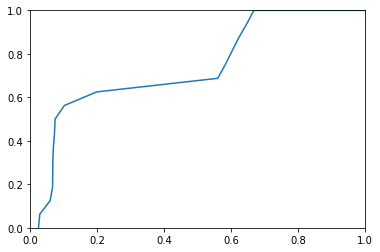

AUC:  0.7388356665665815


In [0]:
import warnings
from sklearn.cluster import KMeans
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
from math import sqrt
from pandas import read_csv
import pandas as pd
from pandas import DataFrame
from pandas import concat
import numpy as np 
from matplotlib import pyplot
from sklearn.svm import OneClassSVM
from sklearn import preprocessing
import sys

class OneClassSVM_AnomalyDetection:

    @classmethod
    def from_DataFrame(cls,dataframe,window_width, dimension, nu, train_rate) -> 'OneClassSVM_AnomalyDetection':
    	return cls(dataframe, dimension, window_width, nu, train_rate)

    @classmethod
    def from_file(cls, path, index_col, window_width, dimension, nu, train_rate) -> 'OneClassSVM_AnomalyDetection':
    	df = read_csv(path, header=0, index_col=index_col, parse_dates=True,squeeze=True)
    	return cls(df, dimension, window_width, nu, train_rate)
     
    def __init__(self,dataframe, dimension, window_width, nu, train_rate):
        self.nu = nu
        self.df = dataframe
        self.window_width = window_width
        self.dimension = dimension
        self.window_width = window_width
		
        self.df = self.df.reset_index(drop=True)
        self.df.rename(columns={'Target':'is_anomaly'}, inplace=True)
        self.df.loc[self.df.is_anomaly == "'Anomaly'", 'is_anomaly'] = 1
        self.df.loc[self.df.is_anomaly == "'Normal'", 'is_anomaly'] = 0

        self.X_origin = self.df.iloc[:,:dimension].values
        self.Y_origin = self.df.iloc[:,-1].values

        df_sensors = pd.DataFrame(self.df.iloc[:,:dimension].values)  
        self.values = df_sensors
        self.dataframe = concat([self.df.iloc[:,:-1].shift(1), self.df.iloc[:,:-1], self.df.iloc[:,-1]], axis=1)
        self.dataframe.columns = np.r_[np.array(['V'+str(i)+'_t' for i in range(1,self.dimension+1)]),np.array(['V'+str(i)+'_t+1' for i in range(1,self.dimension+1)]),['is_anomaly']]

        self.train_size = int(len(self.values) * train_rate)

    def create_XY_lookback_dataset(self,dataset, look_back=1):
        dataX, dataY = [], []
        for i in range(len(dataset)-look_back-1):
            a = dataset[i:(i+look_back),:self.dimension]
            dataX.append(a)
            dataY.append(dataset[i + look_back,:self.dimension].reshape(-1))
        return np.array(dataX), np.array(dataY)

    def build_sets(self):

        X = self.dataframe.iloc[:,:-1].values
        self.train, self.test = X[1:self.train_size], X[self.train_size:]    
        # print('Train.len:',len(self.train),' - Test.len:', len(self.test))

        self.train_X, self.train_y = self.create_XY_lookback_dataset(self.train, self.window_width)
        self.test_X, self.test_y = self.create_XY_lookback_dataset(self.test, self.window_width)
        # print('TrainX.shape:',self.train_X.shape,' - TestX.shape:', self.test_X.shape,' - TrainY.shape:', self.train_y.shape,' - TestY.shape:', self.test_y.shape)

        self.validationsize = int(self.train_X.shape[0] * 0.1)
        self.val, self.test = self.test[:self.validationsize], self.test[self.validationsize:]
        self.val_X, self.val_y= self.test_X[:self.validationsize], self.test_y[:self.validationsize]
        self.test_X, self.test_y = self.test_X[self.validationsize:], self.test_y[self.validationsize:]
        
    def __build_sets(self):
	
        X = self.dataframe.iloc[:,:-1].values
        self.train, self.test = X[1:self.train_size], X[self.train_size:]    
        # print('Train.len:',len(self.train),' - Test.len:', len(self.test))

        self.train_X, self.train_y = self.create_XY_lookback_dataset(self.train, self.window_width)
        self.test_X, self.test_y = self.create_XY_lookback_dataset(self.test, self.window_width)
        # print('TrainX.shape:',self.train_X.shape,' - TestX.shape:', self.test_X.shape,' - TrainY.shape:', self.train_y.shape,' - TestY.shape:', self.test_y.shape)

    def standardize_dataframe(self):
        X = self.dataframe.values[:,:-1]
        self.scalar = preprocessing.StandardScaler().fit(X)
        X = self.scalar.transform(X)
        self.dataframe = pd.DataFrame(np.concatenate((X,self.dataframe.values[:,-1].reshape(-1,1)),axis=1))
        self.dataframe.columns = np.r_[np.array(['V'+str(i)+'_t' for i in range(1,self.dimension+1)]),np.array(['V'+str(i)+'_t+1' for i in range(1,self.dimension+1)]),['is_anomaly']]

    def inverse_standardize_dataframe(self):
        X = self.dataframe.values[:,:-1]
        X = self.scalar.inverse_transform(X)
        self.dataframe = pd.DataFrame(np.concatenate((X,self.dataframe.values[:,-1].reshape(-1,1)),axis=1))
        self.dataframe.columns = np.r_[np.array(['V'+str(i)+'_t' for i in range(1,self.dimension+1)]),np.array(['V'+str(i)+'_t+1' for i in range(1,self.dimension+1)]),['is_anomaly']]

    def model_persistence(self, x):
        return x
        
    def create_persistence(self):
        rmse = sqrt(mean_squared_error(self.dataframe['t'].iloc[self.train_size:], self.dataframe['t+1'].iloc[self.train_size::]))
#         print('Persistent Model RMSE: %.3f' % rmse)   

    def fit(self):
        # self.create_persistence()
        self.standardize_dataframe()
        self.__build_sets()
                
        self.compute_anomalyScores()
        self.inverse_standardize_dataframe()

    def compute_anomalyScores(self):
        self.errors = np.zeros_like(self.test[:,0])
        # compute anomalies
        warnings.filterwarnings("ignore")

        for i,_ in enumerate(self.test[:-self.window_width+1]):
            sys.stdout.write('\r'+str(i)+':'+str(len(self.test) - self.window_width))

            window = self.test[i:i+self.window_width]
            clf=OneClassSVM(nu=self.nu)
            clf.fit(window)
            error = clf.decision_function(window) 
            error[error>0] = 0
            self.errors[i:i+self.window_width] += error*-10


        # normalize anomaly score
        self.errors[:-self.window_width+1] /= self.window_width
        for i,error in enumerate(self.test[-self.window_width+1:]):
            self.errors[-self.window_width + 1 + i] /=self.window_width-(i+1)

        # self.errors_original = self.errors
        # scalar = preprocessing.MinMaxScaler((0,1)).fit(self.errors.reshape(-1,1))
        # self.errors = scalar.transform(self.errors.reshape(-1,1))*10


    def plot(self):
        fig, axes = plt.subplots(nrows=3, ncols=3, dpi=120, figsize=(50,5))
        for i, ax in enumerate(axes.flatten()):
            data = self.df[self.df.columns[i]].iloc[:200]
            ax.plot(self.test_y[:,i], color='green',  linewidth=0.5,label='True Values')
            ax.plot(self.predictions[:,i], color='blue',  linewidth=0.5,label='Predictions')
            ax.plot(self.errors[:,i], color = 'red',  linewidth=0.5, label='Errors')
            ax.legend()
            
        plt.show()

    def get_roc_auc(self, plot=True, verbose=True):
        # get the predicted errors of the anomaly points
        indices = self.df[self.df['is_anomaly']==1].index >self.train_size
        true_anomaly_predicted_errors = self.errors[self.df[self.df['is_anomaly']==1].index[indices] - self.train_size ]
        if len(true_anomaly_predicted_errors) == 0:
            return np.nan
        # sort them 
        true_anomaly_predicted_errors = np.sort(true_anomaly_predicted_errors,axis=0).reshape(-1)
        true_anomaly_predicted_errors_extended = np.r_[np.linspace(0,true_anomaly_predicted_errors[0],40)[:-1],true_anomaly_predicted_errors]
        true_anomaly_predicted_errors_extended = np.r_[true_anomaly_predicted_errors_extended, true_anomaly_predicted_errors_extended[-1] + np.mean(true_anomaly_predicted_errors_extended)]
                # now iterate thru the predicted errors from small to big
        # for each value look how much other points have equal or bigger error
        FPR = [] # fp/n  https://en.wikipedia.org/wiki/Sensitivity_and_specificity
        TPR = [] # tp/p
        p = len(true_anomaly_predicted_errors)
        Thresholds = []
        for predictederror in true_anomaly_predicted_errors_extended:
            threshold = predictederror
            tp = len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>= threshold])
            fp = len(self.errors[self.errors>=threshold])-len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>=threshold])
            
            fpr =fp/len(self.errors)
            FPR.append(fpr)
            TPR.append(tp/p)
            if verbose:
                print("Threshold: {0:25}  - FP: {1:4} - TP: {2:4} - FPR: {3:21} - TPR: {4:4}".format(threshold,fp, tp, fpr, tp/p))

        import matplotlib.pyplot as plt
        if plot:
            plt.figure()
            plt.axis([0, 1, 0, 1])
            plt.plot(FPR,TPR)
            plt.show() 

        # This is the AUC
        from sklearn.metrics import auc
        print('AUC: ' ,auc(FPR,TPR)        )
        return auc(FPR,TPR)



iforest = OneClassSVM_AnomalyDetection.from_file('drive/My Drive/MT/Experiments/Multivariate/NASA_Shuttle/40903.csv',None,30,3,0.7,0.3)
iforest.fit()
auc = iforest.get_roc_auc(verbose=False,plot=True)


In [0]:
iforest.test.shape

(66610, 6)